In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class MTDataset(Dataset):
    def __init__(self, d, t=None):
        self.s = []  
        for i, c in enumerate(['makeup', 'non-makeup']):
            p = os.path.join(d, c)
            if os.path.exists(p):
                for f in os.listdir(p):
                    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.s.append((os.path.join(p, f), i))
        self.t = t
    
   
    

    def __len__(self):
        return len(self.s)

    def __getitem__(self, i):
        img, lbl = Image.open(self.s[i][0]).convert('RGB'), self.s[i][1]
        return self.t(img) if self.t else img, lbl


tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 主程序
if __name__ == "__main__":
    ds = MTDataset("MT-Dataset/images", tf)
    if ds.s:
        dl = DataLoader(ds, 32, shuffle=True, num_workers=0)
        for imgs, lbls in dl:
            print(f"图片形状：{imgs.shape}，标签：{lbls[:5]}")
            break
    else:
        print("无有效样本")

图片形状：torch.Size([32, 3, 224, 224])，标签：tensor([0, 1, 1, 0, 1])


=== 验证Python环境 ===
Python路径: /Users/limengyan/anaconda3/envs/alb_env/bin/python
✅ numpy: 2.2.6
✅ OpenCV: 4.12.0
✅ PyTorch: 2.9.1 (CUDA: False)
✅ Albumentations: 1.3.0

=== 最终环境信息 ===
Albumentations: 1.3.0
NumPy: 2.2.6
PyTorch: 2.9.1
Device: cpu

✅ 加载数据集：3834 张图片

🚀 开始训练 No Augmentation...


No Augmentation Epoch 3/3: 100%|██████████████| 384/384 [01:10<00:00,  5.44it/s]


📊 评估 No Augmentation...
✅ No Augmentation 准确率: 91.00%


✅ 加载数据集：3834 张图片

🚀 开始训练 Basic Augmentation...


Basic Augmentation Epoch 3/3: 100%|███████████| 384/384 [01:09<00:00,  5.52it/s]


📊 评估 Basic Augmentation...
✅ Basic Augmentation 准确率: 90.22%


✅ 加载数据集：3834 张图片

🚀 开始训练 Albumentations Augmentation...


Albumentations Augmentation Epoch 3/3: 100%|██| 384/384 [01:13<00:00,  5.20it/s]


📊 评估 Albumentations Augmentation...
✅ Albumentations Augmentation 准确率: 89.18%



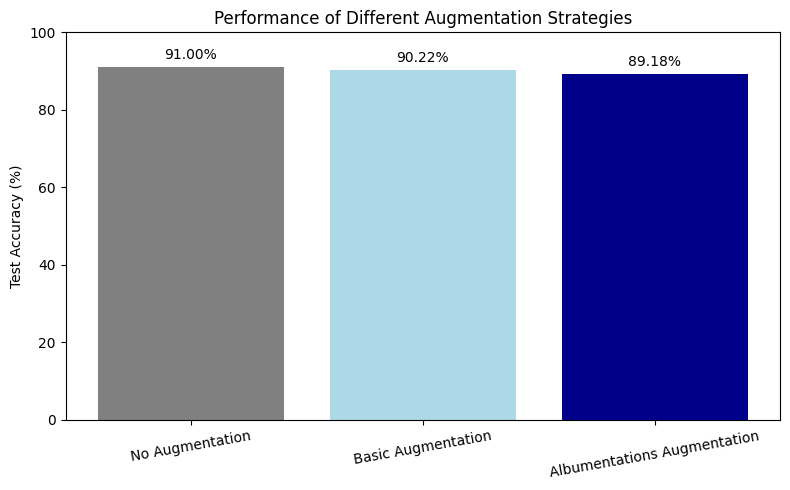


=== 🎯 最终结果汇总 ===
No Augmentation: 91.00%
Basic Augmentation: 90.22%
Albumentations Augmentation: 89.18%


In [3]:
# ====================== 环境验证（第一步） ======================
import sys
import os
import numpy  # 提前导入numpy，避免后续使用时报错
print("=== 验证Python环境 ===")
print(f"Python路径: {sys.executable}")

# 逐个验证核心库
try:
    import numpy
    print(f"✅ numpy: {numpy.__version__}")
except ImportError:
    print("❌ numpy未安装！执行: conda install numpy")
    sys.exit(1)

try:
    import cv2
    print(f"✅ OpenCV: {cv2.__version__}")
except ImportError:
    print("❌ OpenCV未安装！执行: pip install opencv-python")
    sys.exit(1)

try:
    import torch
    print(f"✅ PyTorch: {torch.__version__} (CUDA: {torch.cuda.is_available()})")
except ImportError:
    print("❌ PyTorch未安装！执行: pip install torch torchvision")
    sys.exit(1)

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    print(f"✅ Albumentations: {A.__version__}")  # 必须显示1.3.0
except ImportError:
    print("❌ Albumentations未安装！执行: pip install albumentations==1.3.0")
    sys.exit(1)

# 其他必要库
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.models import ResNet18_Weights
from tqdm import tqdm

# ====================== 极简数据集类 ======================
class SimpleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        # 加载makeup(0)/non-makeup(1)
        for label, cls in enumerate(['makeup', 'non-makeup']):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.exists(cls_dir):
                for f in os.listdir(cls_dir):
                    if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.img_paths.append(os.path.join(cls_dir, f))
                        self.labels.append(label)
            else:
                print(f"⚠️  警告：{cls_dir} 目录不存在，请检查数据集路径！")

        self.transform = transform
        print(f"\n✅ 加载数据集：{len(self.img_paths)} 张图片")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # 加载图片（容错处理）
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            img = numpy.zeros((224, 224, 3), dtype=numpy.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 应用增强
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, self.labels[idx]

# ====================== 定义增强策略（修复1.3.0版本兼容问题） ======================
IMG_HEIGHT = 224
IMG_WIDTH = 224
# 归一化参数（补充max_pixel_value，避免归一化错误）
norm = A.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225],
    max_pixel_value=255.0  # 关键补充：1.3.0版本建议显式指定
)

# 策略1：无增强
no_aug = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    norm,
    ToTensorV2()
])

# 策略2：基础增强（修复RandomRotation → Rotate）
basic_aug = A.Compose([
    A.RandomResizedCrop(height=IMG_HEIGHT, width=IMG_WIDTH, scale=(0.8, 1.0)),
    A.Rotate(limit=10),  # 核心修复：RandomRotation → Rotate
    norm,
    ToTensorV2()
])

# 策略3：Albumentations增强（修复RandomRotation → Rotate）
alb_aug = A.Compose([
    A.RandomResizedCrop(height=IMG_HEIGHT, width=IMG_WIDTH, scale=(0.7, 1.0)),
    A.Rotate(limit=15),  # 核心修复：RandomRotation → Rotate
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2),
    A.GaussNoise(p=0.1),
    norm,
    ToTensorV2()
])

# ====================== 训练评估函数（逻辑不变） ======================
def train_eval(transform, name, device, data_root):
    # 加载数据集
    dataset = SimpleDataset(data_root, transform=transform)
    if len(dataset) < 5:
        print(f"❌ 跳过 {name}：样本数不足")
        return 0, numpy.zeros((2,2))
    
    # 划分数据集
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    
    # 创建DataLoader
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)
    
    # 加载模型
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    # 冻结主干
    for param in model.parameters():
        param.requires_grad = False
    # 替换分类头
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)
    
    # 训练配置
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    
    # 训练（简化版）
    print(f"\n🚀 开始训练 {name}...")
    model.train()
    for epoch in range(3):  # 少量轮数快速验证
        for imgs, labels in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/3"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # 评估
    print(f"📊 评估 {name}...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds) * 100
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
    
    # 绘制混淆矩阵
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['makeup', 'non-makeup'],
                yticklabels=['makeup', 'non-makeup'])
    plt.title(f"{name}\nAccuracy: {acc:.2f}%")
    plt.tight_layout()
    plt.savefig(f"cm_{name.replace(' ', '_')}.png")
    plt.close()
    
    return acc, cm

# ====================== 主程序 ======================
if __name__ == "__main__":
    # 环境配置
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DATA_ROOT = "MT-Dataset/images"  # 替换为你的数据集实际路径
    
    # 打印版本信息
    print("\n=== 最终环境信息 ===")
    print(f"Albumentations: {A.__version__}")
    print(f"NumPy: {numpy.__version__}")
    print(f"PyTorch: {torch.__version__}")
    print(f"Device: {DEVICE}")
    
    # 检查数据集路径是否存在
    if not os.path.exists(DATA_ROOT):
        print(f"\n❌ 错误：数据集路径 {DATA_ROOT} 不存在！")
        print("请确保路径下有 'makeup' 和 'non-makeup' 两个子目录")
        sys.exit(1)
    
    # 运行所有策略
    strategies = [
        ("No Augmentation", no_aug),
        ("Basic Augmentation", basic_aug),
        ("Albumentations Augmentation", alb_aug)
    ]
    
    results = {}
    for name, transform in strategies:
        acc, _ = train_eval(transform, name, DEVICE, DATA_ROOT)
        results[name] = acc
        print(f"✅ {name} 准确率: {acc:.2f}%\n")
    
    # 绘制准确率对比图
    plt.figure(figsize=(8,5))
    names = list(results.keys())
    accs = list(results.values())
    colors = ['gray', 'lightblue', 'darkblue']
    
    plt.bar(names, accs, color=colors)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Performance of Different Augmentation Strategies")
    plt.ylim(0, 100)
    
    # 添加数值标签
    for i, (n, a) in enumerate(zip(names, accs)):
        plt.text(i, a+2, f"{a:.2f}%", ha='center')
    
    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.savefig("accuracy_comparison.png")
    plt.show()
    
    # 打印最终结果
    print("\n=== 🎯 最终结果汇总 ===")
    for name, acc in results.items():
        print(f"{name}: {acc:.2f}%")